In [203]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from planning_utils import create_grid, a_star

import utm
import numpy

%matplotlib inline 


In [204]:
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.frame_utils import *
from udacidrone.messaging import MsgID

In [205]:
plt.rcParams['figure.figsize'] = 8, 8

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [206]:
?create_grid

In [207]:
def global_to_local(global_position, global_home):
    
    (east_home, north_home, _, _) = utm.from_latlon(global_home[1], global_home[0])
    
    (east, north, _, _) = utm.from_latlon(global_position[1], global_position[0])
                                          
    local_position = numpy.array([north - north_home, east - east_home, -global_position[2]])
    
    return local_position

In [208]:
def local_to_global(local_position, global_home):
    (east_home, north_home, zone_number, zone_letter) = utm.from_latlon(
                                                        global_home[1], global_home[0])
    
    (lat, lon) = utm.to_latlon(east_home + local_position[1],
                               north_home + local_position[0], zone_number,
                               zone_letter)
                               
    global_position = numpy.array([lon, lat, -local_position[2]])
    
    return global_position

In [209]:
s_lat0, s_lon0 = pd.read_csv('colliders.csv', nrows=1)

lat0 = np.float64(s_lat0.split(' ')[1])
lon0 = np.float64(s_lon0.split(' ')[2])

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [210]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [211]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 5

In [212]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid, north_min, east_min = create_grid(data, drone_altitude, safe_distance)

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [213]:
# start_ne = (240, 380)
# start_ne = (315, 445)
start_ne = (-north_min, -east_min)
# goal_ne = (580., 750.)
# goal_ne = (824., 315.)
goal_ne = (815., 289.)

Write a heuristic function.

In [214]:
def heuristic_func2(position, goal_position):
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

In [215]:
def heuristic_func(position, goal_position):
    D = 1
    D2 = np.sqrt(2)
    
    dx = np.abs(position[0] - goal_position[0])
    dy = np.abs(position[1] - goal_position[1])
    
#     if dx > dy: 
#         return D * (dx-dy) + D2 * dy
#     else: 
#         return D * (dy-dx) + D2 * dx
    
#     return 10 * (dx + dy) - 6 * min(dx, dy)
#     return D * max(dx, dy) + (D2-1) * min(dx, dy)

    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)

In [216]:
def heuristic_func3(position, goal_position):
    dx = np.abs(position[0] - goal_position[0])
    dy = np.abs(position[1] - goal_position[1])
    return min(dx, dy) * np.sqrt(2) + abs(dx - dy)

In [217]:
def heuristic_func4(position, goal_position):
    D = 1
    dx = np.abs(position[0] - goal_position[0])
    dy = np.abs(position[1] - goal_position[1])
    return D * np.sqrt(dx * dx + dy * dy)

Compute the lowest cost path with `a_star`. 

In [218]:
path, cost = a_star(grid, heuristic_func2, start_ne, goal_ne)
# path, cost = a_star(grid, heuristic_func2, start_ne, goal_ne)
print(len(path), cost)

Found a path.
572 172824.9215200003


Let's plot the path!

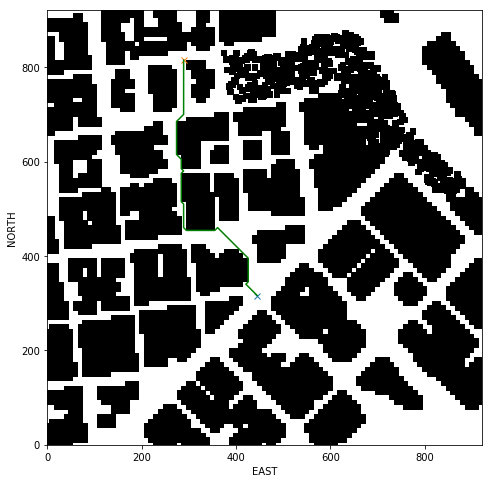

In [219]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Path Pruning

In [220]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

In [221]:
# We're using collinearity here, but you could use Bresenham as well!
def colinear_prune_path(path):
    pruned_path = [p for p in path]
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

Prune the path.

In [222]:
pruned_path = colinear_prune_path(path)
print(len(pruned_path))

18


In [223]:
def bresenham(p1, p2):
    sign = 1

    if p1[0] > p2[0]:
        _x0 = int(p1[0])
        _x1 = int(p2[0])

        _y0 = int(p1[1])
        _y1 = int(p2[1])

        p1 = (_x1, _y1)
        p2 = (_x0, _y0)

    if p1[1] > p2[1]:
        sign = -1

    x1, y1 = p1
    x2, y2 = p2

    cells = []

    m = abs(y2 - y1) / abs(x2 - x1)

    if sign == 1:
        line_val = y1
        i = x1
        j = y1
        r = i
        k = x2
        while i < x2:
            cells.append([i, j])
            if line_val + m > j + 1:
                j += 1
            else:
                line_val += m
                i += sign
    else:
        line_val = y2
        i = x2
        j = y2

        while x1 < i:
            cells.append([i, j])
            if line_val + m > j + 1:
                j += 1
            else:
                line_val += m
                i += sign

    cells.append([i, j])
    return np.array(cells)

In [224]:
def bres_prune_path(grid, pruned_path):
    pp = list(pruned_path)

    p1 = (int(pp[0][0]), int(pp[0][1]))
    path = []
    path.append(p1)
    i = 1
    
    while i < len(pp):
        p2 = (int(pp[i][0]), int(pp[i][1]))
        
        b_pp = bresenham(p1, p2)
    
        for p in b_pp:
            x = p[0]
            y = p[1]
            
            if grid[int(x)][int(y)] == 1:
                p1 = pp[i-1]
                path.append(pp[i-1])
                break        
        
        i = i+1
        
    path.append(pp[-1])       
    return path    

In [225]:
res = prune_path2(grid, path)
print(len(res))

14


In [226]:
res2 = prune_path2(grid, res)
print(len(res2))

12


[[5 0]
 [5 1]
 [4 1]
 [4 2]
 [3 2]
 [3 3]
 [3 4]
 [2 4]
 [2 5]
 [1 5]
 [1 6]
 [0 6]]


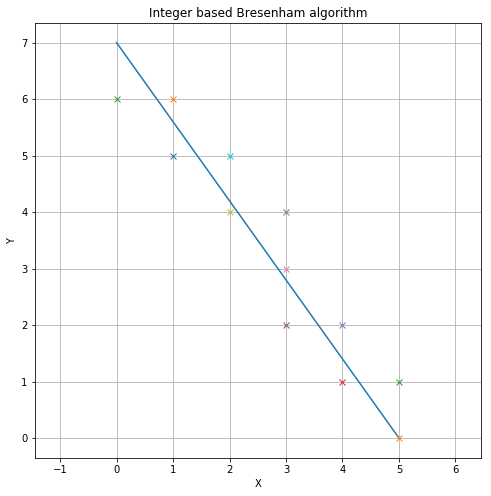

In [227]:
plt.rcParams['figure.figsize'] = 8, 8

p1 = [0, 7]
p2 = [5, 0]

# p2 = [0, 0]
# p1 = [5, 7]

cells = bresenham(p1, p2)
print(cells)

plt.plot([p1[0], p2[0]], [p1[1], p2[1]])

    
for q in cells:
    plt.plot(q[0], q[1], 'x')
#     plt.plot([q[0], q[0]+1], [q[1]+1, q[1]+1], 'x')
#     plt.plot([q[0], q[0]], [q[1],q[1]+1], 'x')
#     plt.plot([q[0]+1, q[0]+1], [q[1], q[1]+1], 'x')

plt.grid()
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Integer based Bresenham algorithm")
plt.show()

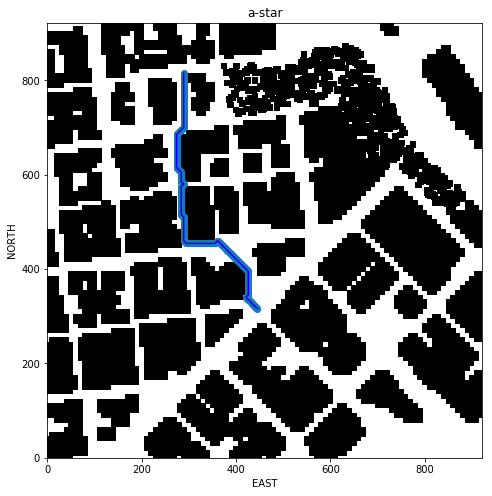

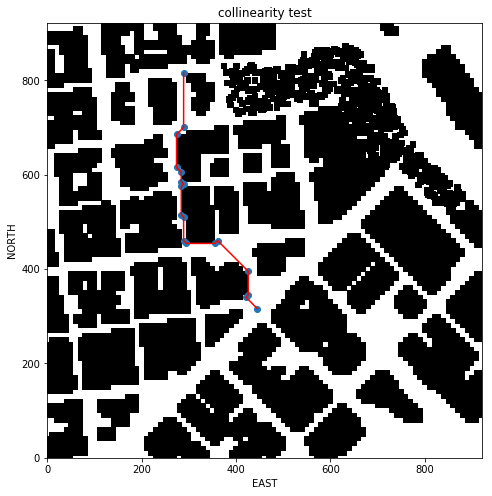

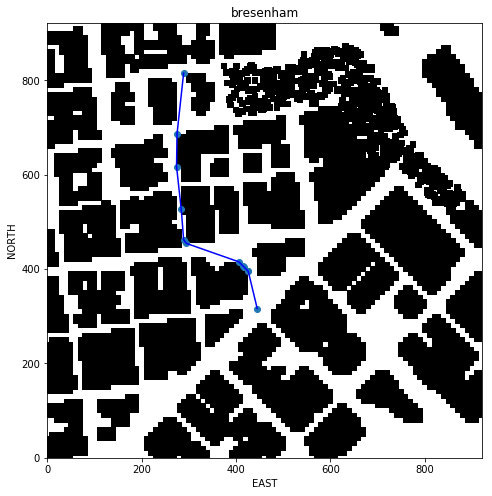

In [228]:
pp1 = np.array(path)
plt.figure(1)
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(pp1[:, 1], pp1[:, 0], 'b')
plt.scatter(pp1[:, 1], pp1[:, 0])
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('a-star')
plt.savefig("a_star.png")

pp2 = np.array(pruned_path)
plt.figure(2)
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(pp2[:, 1], pp2[:, 0], 'r')
plt.scatter(pp2[:, 1], pp2[:, 0])
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('collinearity test')
plt.savefig("collinear.png")

pp3 = np.array(res2)
plt.figure(3)
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(pp3[:, 1], pp3[:, 0], 'b')
plt.scatter(pp3[:, 1], pp3[:, 0])
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('bresenham')
plt.savefig("bres.png")

plt.show()